## **QRT Data Challenge: Stock Return Prediction**

#### Auteur: Naïl Khelifa

In [1]:
# pour éviter de surchager les outputs de cellules avec des warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Packages

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV

import utils

### Chargement des données

In [3]:
x_train = pd.read_csv('x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv('y_train_JQU4vbI.csv', index_col='ID')
x_test = pd.read_csv('x_test_c7ETL4q.csv', index_col='ID')

In [4]:
x_train.head(5)

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


In [5]:
print(f"on a {x_train.shape[0]} observations de {x_test.shape[1]} features")
print(f"on a {len(x_train['STOCK'].unique())} actifs")

on a 418595 observations de 46 features
on a 5350 actifs


#### **Remarques sur les données de `x_train`**

On dispose donc de 47 features et de 418595 observations. Cependant, à l'observation des 5 premières lignes de x_train, on observe qu'il y a des valeurs manquantes. On souhaite corriger ces NaN. Une première chose à faire est donc de nettoyer `x_train`. On remarque que si l'on retire les lignes associées à ces valeurs manquantes, on perd trop d'information sur certains stocks, cest pourquoi on remplace les valeurs manquantes par 0.

In [85]:
x_train.fillna(0., inplace=True)
x_test.fillna(0., inplace=True)

En observant `y_train`, on se rend compte qu'il s'agit un problème de classification binaire. À partir de là, une première approche de sélection de feature est d'étudier la répartition de chaque feature dans chaque classe. 

In [18]:
# on ajoute la colonne associée aux labels dans le dataset d'entraînement
y_train['RET'] = y_train['RET'].replace({True: 1, False: 0})
x_train['RET'] = y_train['RET']

## **Étude des features quantitatifs** 

Dans un premier temps, on laisse de côté les features qualitatif (secteur, industrie...) et on se concentre sur les features purement qualitatifs. 

On commence par transformer le dataset. On aimerait avoir une base de données avec en ligne le numéro du stock et avec en colonne les features. De sorte à ce que chaque élément du dataset correspondent à une liste contenant toute les observations de ce feature pour le stock donné.

In [19]:
transformed_x_train, transformed_x_test = utils.transform_data(x_train, x_test)
transformed_x_train.head(3)

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,...,VOLUME_12,VOLUME_13,VOLUME_14,VOLUME_15,VOLUME_16,VOLUME_17,VOLUME_18,VOLUME_19,VOLUME_20,RET
STOCK,,,,,,,,,,,,,,,,,,,,,
0,"[-0.0059669713617936, 0.0013480334825179, -0.0...","[0.0090308307725444, 0.0111001907845291, 0.003...","[0.0082959410164575, 0.0120226233112301, 0.011...","[0.0026378992025406, -0.0164769150555652, 0.0,...","[0.0127389308754382, 0.0056537102473497, 0.002...","[0.0397343401153809, -0.0221122047125944, 0.00...","[-0.0008532613707511, -0.0092543746755998, -0....","[0.0289919491779371, 0.0037911636723635, 0.008...","[-0.0028476123980203, 0.0072568578981995, 0.00...","[-0.0060941142695922, -0.002856254598056, 0.00...",...,"[-0.3923386495123397, -0.4495899611488715, -0....","[0.0353919262672781, -0.3724656577168361, -0.1...","[0.0412995896712173, -0.2261815985241434, -0.2...","[-0.3820672562396299, -0.2491427625121033, -0....","[-0.4933543586370698, -0.3135752471239016, -0....","[-0.5854972515334218, 0.0713381754702875, -0.4...","[-0.3513631830822069, -0.4052426590921026, -0....","[-0.3246745173072086, -0.4243361656776324, -0....","[-0.2917506195727448, -0.0505914141416463, -0....","[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
1,"[0.0139480421946516, 0.0019941044480866, -0.01...","[0.0110060493650638, 0.0025438038360814, -0.00...","[0.0008603721520819, -0.0068577013987881, 0.02...","[0.0230673945403454, -0.0087657903424789, 0.01...","[0.0049551900170163, -0.0021418120664983, 0.00...","[0.0196678342513889, 0.0035827545016209, -0.00...","[-0.0044907544727136, -0.007996974102978, -0.0...","[0.0138407153783997, 0.0024942299215666, -0.01...","[-0.0093810950166882, 0.0064549352778766, -0.0...","[-0.0076977478345955, -0.0143159597131535, 0.0...",...,"[0.0, -0.4410877458725768, 1.531594376956409, ...","[0.0, -0.8266127880604341, 0.1483056631790651,...","[0.0, -0.502413935729947, 0.4012110801698862, ...","[0.0, -0.3674982061231675, 0.0, 0.220457882028...","[0.0, -0.8667725277161855, 0.0, -0.02651041373...","[0.0, -1.2012673556063698, 0.0, 0.534877413061...","[0.0, -0.4069068881432085, 0.0, 0.254452264305...","[0.0, -0.5754493468709349, 0.0, -0.50689939484...","[0.0, -0.675792829292539, 0.0, -0.278586535763...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, ..."
2,"[-0.0157480376960778, -0.0186708006623838, 0.0...","[-0.0155038819782489, -0.0177996320386364, -0....","[0.0109715930586977, -0.0200848361746395, -0.0...","[-0.0146716272863426, 0.0096056640386852, -0.0...","[0.0164833234857386, -0.0136847404433528, -0.0...","[0.014331213043633, 0.0354227761735532, -0.047...","[-0.017214593114241, 0.0082413484179528, 0.022...","[-0.018432802777574, 0.0294122097088587, -0.03...","[0.1341459059233449, 0.0406123077801421, -0.03...","[0.1822866071798679, 0.0011786989173381, -0.02...",...,"[-0.8164356492560926, -0.9031327258350536, 0.3...","[-0.2446359693803419, 0.0383966279717538, -1.1...","[-2.042623524632501, -0.5204619377793476, -0.2...","[-0.3696051463408142, -0.4934501640684579, 0.9...","[0.6308990270609234, -0.214853856386497, 0.373...","[-0.3794117706532677, -0.8008054368430658, 1.0...","[-0.1105968799677701, 0.2820388228709516, 0.39...","[0.1745206392456959, -0.2414214293544292, -0.6...","[-0.0009372680030632, 4.528611542082178, -0.49...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, ..."


La première chose que l'on remarque est que les obervations sont inégales d'un stock à l'autre. Si on regarde le nombre d'observations pour la variable `RET_1` on voit par exemple que 

Text(0.5, 1.0, "Distribution des longueurs des éléments dans transformed_x_train['RET_1']")

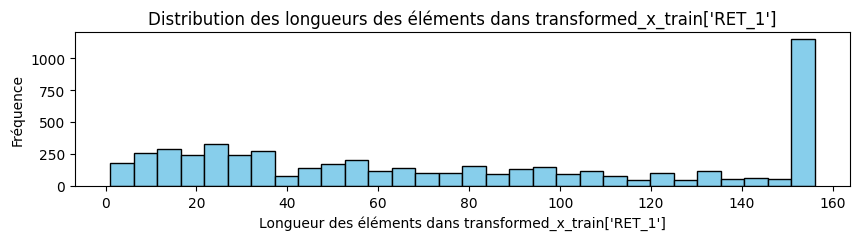

In [20]:
# Calcul des longueurs pour chaque élément dans transformed_x_train['RET_1']
lengths = [len(transformed_x_train['RET_1'][i]) for i in transformed_x_train.index]

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(10, 2))

# Tracer l'histogramme
ax.hist(lengths, bins=30, color='skyblue', edgecolor='black')
ax.set_xlabel('Longueur des éléments dans transformed_x_train[\'RET_1\']')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution des longueurs des éléments dans transformed_x_train[\'RET_1\']')

Ce constat, qui peut être généralisé aux autres variables d'intérêts, nous incite à 

1. travailler sur chaque actif séparément 
2. travailler sur des statistiques agrégées pour chaque actif.

On commence dans un premier temps par définir la routine `one_stock_returns` qui crée un dataset de manière plus maléable pour entraîner un modèle prédictif en ne tenant compte que des données de rendement et de volume associées à un unique stock numéroté par `ID`.

In [21]:
## Par exemple pour le stock 1

transformed_1_train, transformed_1_test = utils.one_stock_returns(1, transformed_x_train, transformed_x_test)

transformed_1_train.head(3)

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,...,VOLUME_12,VOLUME_13,VOLUME_14,VOLUME_15,VOLUME_16,VOLUME_17,VOLUME_18,VOLUME_19,VOLUME_20,RET
0,0.013948,0.011006,0.000860,0.023067,0.004955,0.019668,-0.004491,0.013841,-0.009381,-0.007698,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.001994,0.002544,-0.006858,-0.008766,-0.002142,0.003583,-0.007997,0.002494,0.006455,-0.014316,...,-0.441088,-0.826613,-0.502414,-0.367498,-0.866773,-1.201267,-0.406907,-0.575449,-0.675793,0
2,-0.014093,-0.002237,0.023218,0.012080,0.006999,-0.003983,-0.038308,-0.013697,-0.005635,0.003929,...,1.531594,0.148306,0.401211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


On crée désormais une routine `add_features`, qui prend en argument un dataset (typiquement rendu par `one_stock_returns`), et qui ajoute des features pertinents. On ajoute un argument par défaut `split` qui, lorsqu'il vaut `True` renvoie également le dataset transformé associé à chaque sous classe. 

In [22]:
transformed_X_stock_1, class_0_stock_1, class_1_stock_1 = utils.add_features(transformed_1_train)
transformed_X_stock_1.head(3)

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,...,MEAN_RET_5,MEAN_VOL_20,STD_VOL_20,STD_RET_20,STD_RET_5,cum_RET_5,cum_RET_10,cum_RET_20,RET_Trend_20,RET_slope_5
0,0.013948,0.011006,0.000860,0.023067,0.004955,0.019668,-0.004491,0.013841,-0.009381,-0.007698,...,-0.012773,-0.047199,0.047743,0.014384,0.005513,0.054858,0.067132,-0.034968,-0.030461,-0.005118
1,0.001994,0.002544,-0.006858,-0.008766,-0.002142,0.003583,-0.007997,0.002494,0.006455,-0.014316,...,-0.001827,-0.507398,0.505970,0.008629,0.008894,-0.013209,-0.022976,-0.030345,-0.014272,0.004011
2,-0.014093,-0.002237,0.023218,0.012080,0.006999,-0.003983,-0.038308,-0.013697,-0.005635,0.003929,...,0.000348,0.051961,0.055322,0.014373,0.015936,0.025829,-0.032532,-0.030856,0.027790,0.020459


Le dataset est tout de suite beaucoup plus maléable, et on a 103 observations avec les prédictions associées pour entraîner un modèle à prédire.

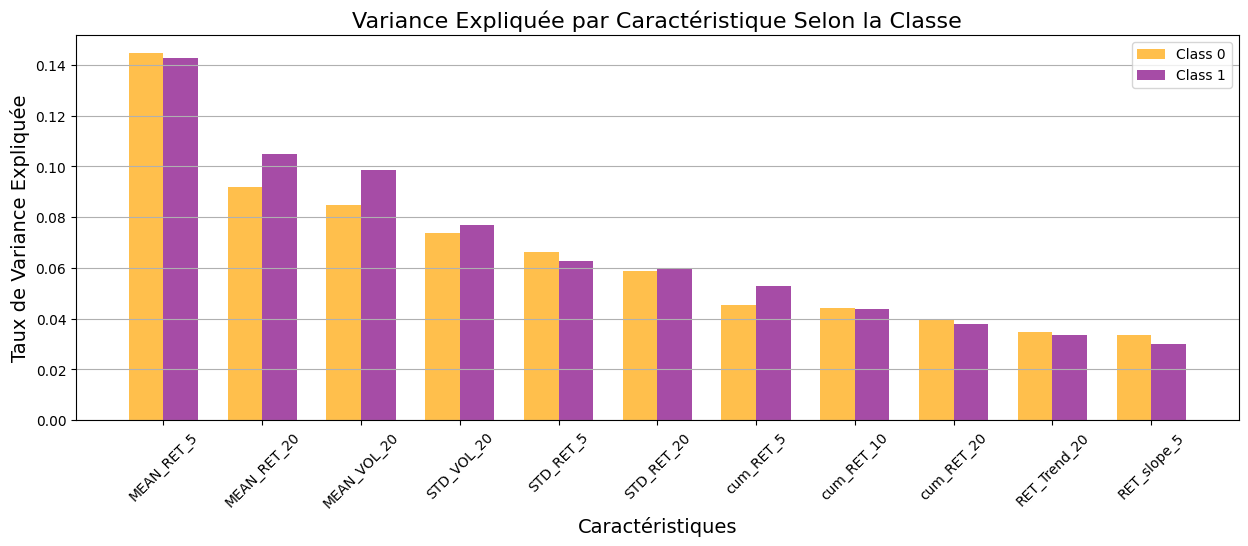

In [23]:
# Liste des caractéristiques à analyser
features_list = ['MEAN_RET_5', 'MEAN_RET_20', 'MEAN_VOL_20', 'STD_VOL_20', 'STD_RET_5', 'STD_RET_20', 'cum_RET_5', 'cum_RET_10', 'cum_RET_20', 'RET_Trend_20', 'RET_slope_5']

utils.PCA_two_classes(features_list, class_0_stock_1, class_1_stock_1)


On voit que les variables `MEAN_RET_20`, `MEAN_VOL_20`, `CUM_RET_5` et `RET_slope_5` sont intéressantes car associées à des différentiels de variance expliquée entre les deux populations. 

On poursuit cette analyse en traçant les boxplots et les histogrammes suivants. 

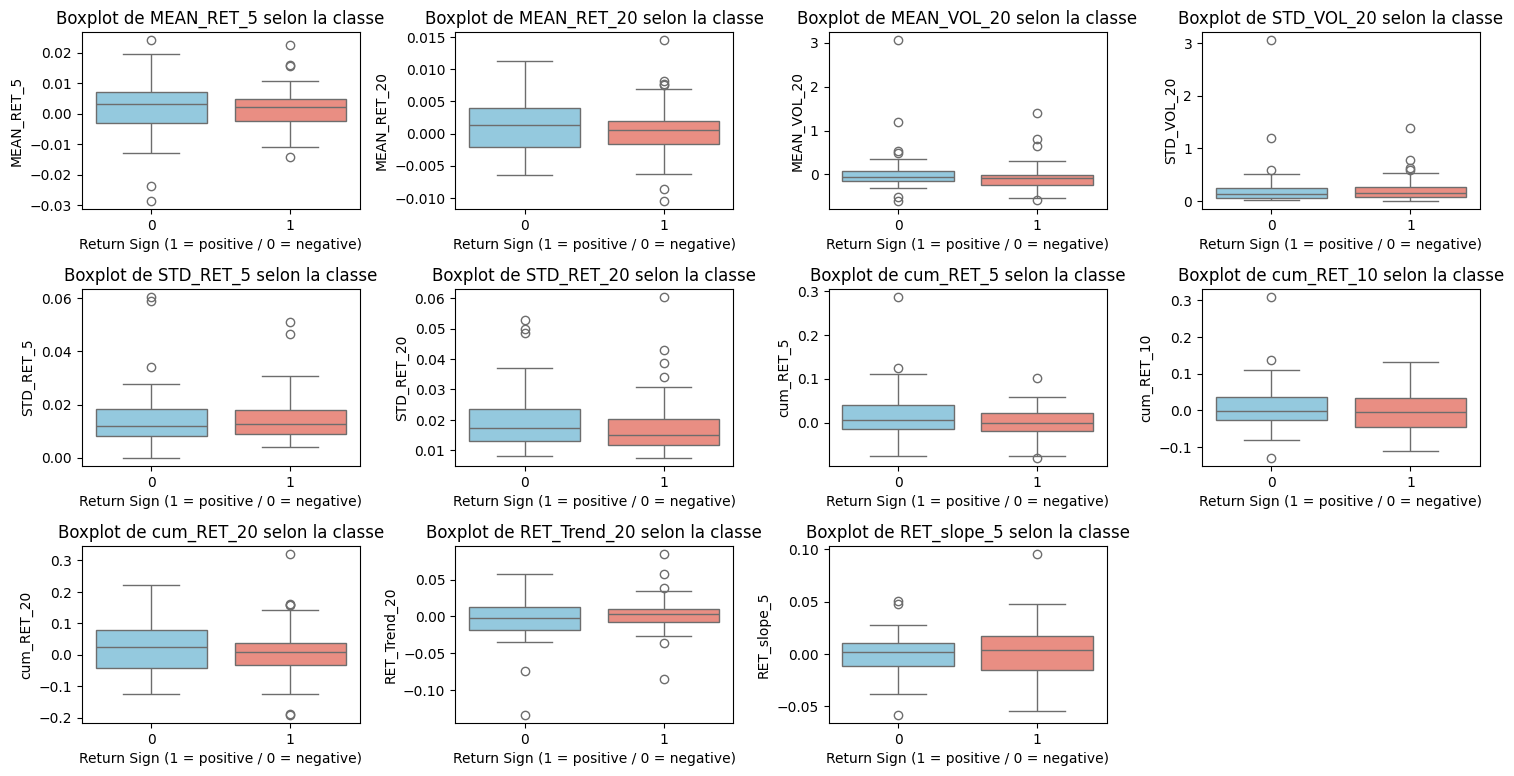

In [24]:
# Variables à tracer
features_list = ['MEAN_RET_5', 'MEAN_RET_20', 'MEAN_VOL_20', 'STD_VOL_20', 'STD_RET_5', 'STD_RET_20', 'cum_RET_5', 'cum_RET_10', 'cum_RET_20', 'RET_Trend_20', 'RET_slope_5']


utils.boxplots(features_list, transformed_X_stock_1)

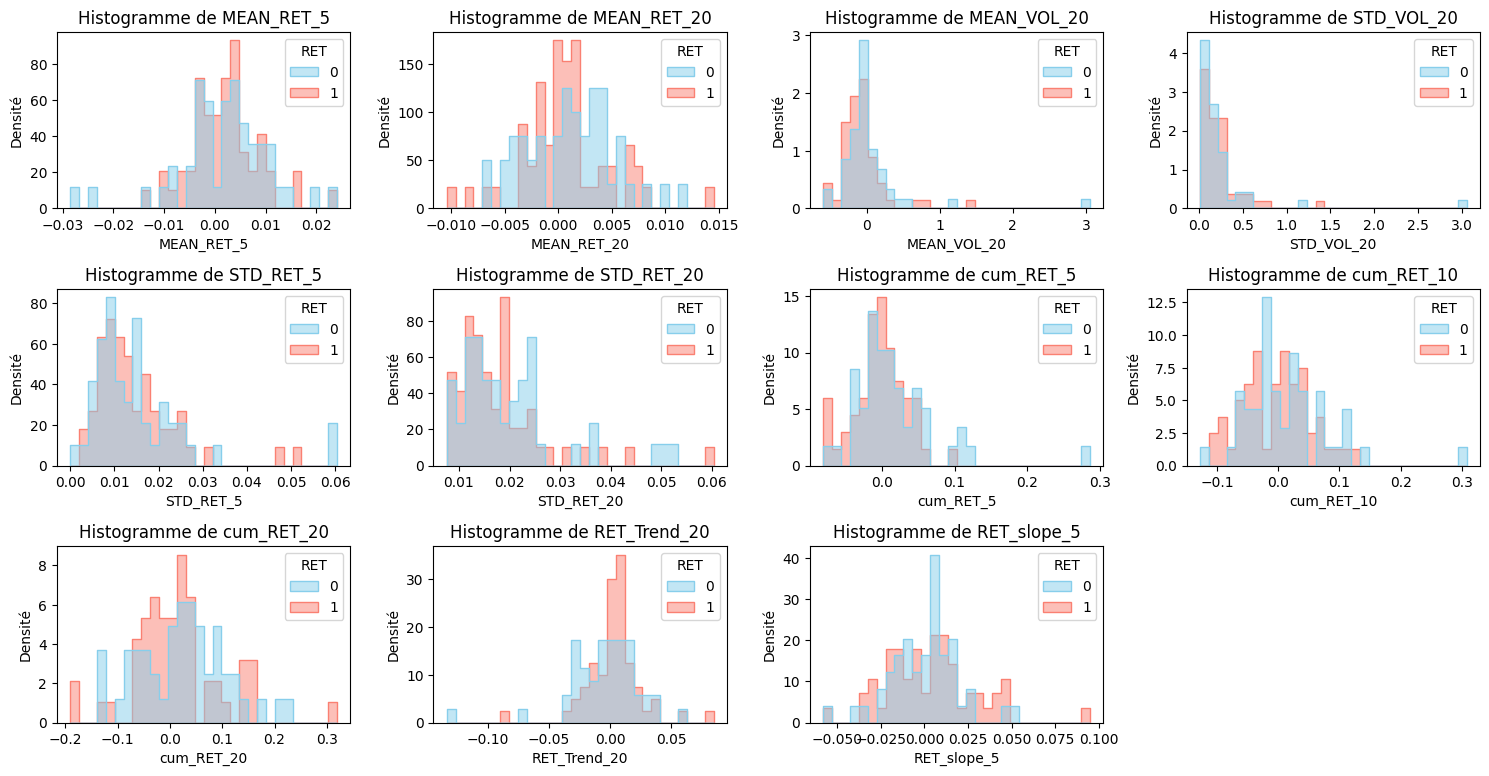

In [26]:
# Tracer les histograms
utils.histogrames(features_list, transformed_X_stock_1)

### **Test avec `RandomForestClassfier()` et `GradientBoostingClassifier()`**

On retient `MEAN_RET_20`, `MEAN_VOL_20`, `CUM_RET_5` et `RET_slope_5`.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleure profondeur : 7
Meilleure accuracy moyenne : 65.86%
Nombre d'arbre optimal : 200


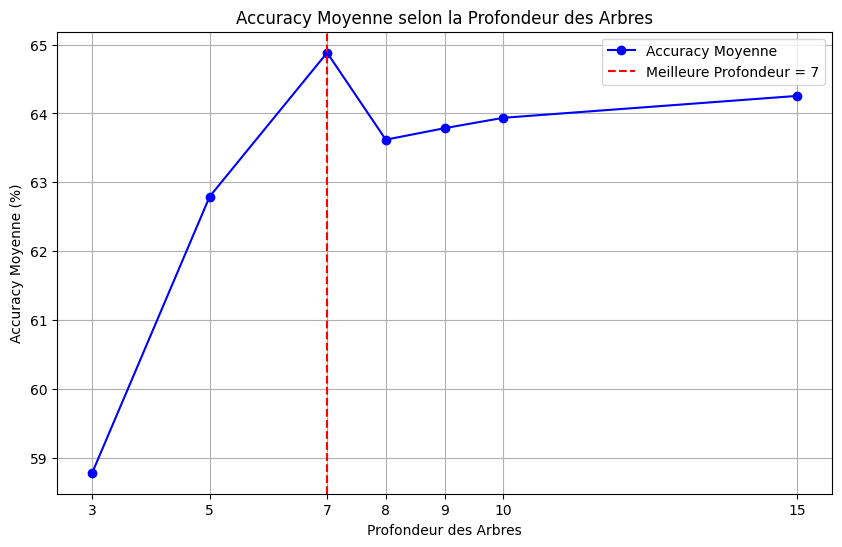

In [56]:
# Liste des features et target
features_list = ['MEAN_RET_20', 'MEAN_VOL_20', 'cum_RET_5', 'RET_slope_5']
X_train = transformed_X_stock_1[features_list].fillna(0)
y_train = transformed_X_stock_1['RET']

# Définir la grille d'hyperparamètres (profondeur des arbres de 3 à 15)
param_grid = {
    'n_estimators': [100, 175, 200, 225, 250, 500],
    'max_depth': [3, 5, 7, 8, 9, 10, 15]
}

# Configurer GridSearchCV avec K-Fold Cross-Validation (5 plis)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
model = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
best_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_
optimal_nb_tree  = grid_search.best_params_['n_estimators']

print(f"Meilleure profondeur : {best_depth}")
print(f"Meilleure accuracy moyenne : {best_score * 100:.2f}%")
print(f"Nombre d'arbre optimal : {optimal_nb_tree}")

# Récupérer les résultats par profondeur
results = grid_search.cv_results_
mean_accuracies = []
depth_range = param_grid['max_depth']

# Calculer l'accuracy moyenne pour chaque profondeur
for depth in depth_range:
    # Sélectionner les indices où la profondeur est égale à `depth`
    indices = [i for i, param in enumerate(results['param_max_depth']) if param == depth]
    # Calculer la moyenne des scores pour ces indices
    mean_score = np.mean([results['mean_test_score'][i] for i in indices])
    mean_accuracies.append(mean_score)

# Tracer l'accuracy moyenne selon la profondeur
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(depth_range, np.array(mean_accuracies) * 100, marker='o', linestyle='-', color='b', label='Accuracy Moyenne')
ax.set_title("Accuracy Moyenne selon la Profondeur des Arbres")
ax.set_xlabel("Profondeur des Arbres")
ax.set_ylabel("Accuracy Moyenne (%)")
ax.set_xticks(depth_range)
ax.grid()
ax.axvline(x=best_depth, color='r', linestyle='--', label=f'Meilleure Profondeur = {best_depth}')
ax.legend()

plt.show()

Meilleure profondeur : 3
Meilleure accuracy moyenne : 74.48%
Nombre d'arbre optimal : 500


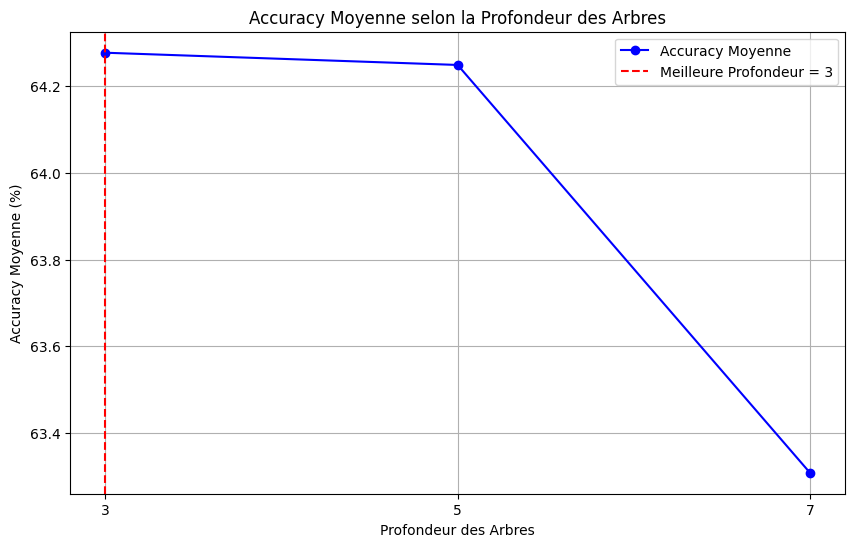

In [57]:
# Liste des features et target
features_list = ['MEAN_RET_20', 'MEAN_VOL_20', 'cum_RET_5', 'RET_slope_5']
X_train = transformed_X_stock_1[features_list].fillna(0)
y_train = transformed_X_stock_1['RET']

# Définir la grille d'hyperparamètres (profondeur des arbres de 3 à 15)
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.6, 0.8, 1.0]
}

# Configurer GridSearchCV avec K-Fold Cross-Validation (5 plis)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
model = GradientBoostingClassifier(random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
best_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_
optimal_nb_tree  = grid_search.best_params_['n_estimators']

print(f"Meilleure profondeur : {best_depth}")
print(f"Meilleure accuracy moyenne : {best_score * 100:.2f}%")
print(f"Nombre d'arbre optimal : {optimal_nb_tree}")

# Récupérer les résultats par profondeur
results = grid_search.cv_results_
mean_accuracies = []
depth_range = param_grid['max_depth']

# Calculer l'accuracy moyenne pour chaque profondeur
for depth in depth_range:
    # Sélectionner les indices où la profondeur est égale à `depth`
    indices = [i for i, param in enumerate(results['param_max_depth']) if param == depth]
    # Calculer la moyenne des scores pour ces indices
    mean_score = np.mean([results['mean_test_score'][i] for i in indices])
    mean_accuracies.append(mean_score)

# Tracer l'accuracy moyenne selon la profondeur
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(depth_range, np.array(mean_accuracies) * 100, marker='o', linestyle='-', color='b', label='Accuracy Moyenne')
ax.set_title("Accuracy Moyenne selon la Profondeur des Arbres")
ax.set_xlabel("Profondeur des Arbres")
ax.set_ylabel("Accuracy Moyenne (%)")
ax.set_xticks(depth_range)
ax.grid()
ax.axvline(x=best_depth, color='r', linestyle='--', label=f'Meilleure Profondeur = {best_depth}')
ax.legend()

plt.show()

### **Régression logistique**

### **Test sur la régression logistique**

In [60]:
# Liste des features et target
features_list = ['MEAN_RET_20', 'MEAN_VOL_20', 'cum_RET_5', 'RET_slope_5']
X_train = transformed_X_stock_1[features_list].fillna(0)
y_train = transformed_X_stock_1['RET']

# Définir la grille d'hyperparamètres
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-5, 1e-6]
}

# Configurer GridSearchCV avec K-Fold Cross-Validation (5 plis)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
model = LogisticRegression(random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
best_pen = grid_search.best_params_['penalty']
best_score = grid_search.best_score_

print(f"Meilleure pénalisation : {best_pen}")
print(f"Meilleure accuracy moyenne : {best_score * 100:.2f}%")

# Récupérer les résultats par profondeur
results = grid_search.cv_results_
mean_accuracies = []


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was

Meilleure pénalisation : l2
Meilleure accuracy moyenne : 65.05%


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was

In [63]:
X_train

,MEAN_RET_20,MEAN_VOL_20,cum_RET_5,RET_slope_5
0,-0.001674,-0.047199,0.054858,-0.005118
1,-0.001502,-0.507398,-0.013209,0.004011
2,-0.001462,0.051961,0.025829,0.020459
3,0.001167,0.222422,-0.006297,0.047626
4,0.001227,-0.009661,0.015759,0.014836
...,...,...,...,...
98,-0.002136,0.089943,-0.068082,-0.005806
99,0.003931,-0.025694,-0.017912,-0.036313
100,-0.001113,-0.493065,-0.012158,0.015671
101,-0.003222,-0.165331,-0.075471,-0.002357


In [67]:
# Définir la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [500],
    'learning_rate': [0.05],
    'max_depth': [3],
}

# Initialiser le modèle
model = GradientBoostingClassifier(random_state=0)

# Configurer K-Fold Cross-Validation (5 plis)
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Configurer GridSearchCV avec le modèle et la grille d'hyperparamètres
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Meilleurs paramètres : {best_params}")
print(f"Meilleure accuracy moyenne : {best_score * 100:.2f}%")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   2.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time=   1.2s
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Meilleure accuracy moyenne : 73.43%


In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

# Random Forest parameters
rf_params = {
    'n_estimators': 500,
    'max_depth': 3,
    'learning_rate': 0.05,
    'min_samples_split': 5, # [2, 5, 10]
    'min_samples_leaf': 2, # [1, 2, 5]
    'subsample': 0.4 # [0.6, 0.8, 1.0]
}

features_list = ['MEAN_RET_20', 'MEAN_VOL_20', 'cum_RET_5', 'RET_slope_5']
X_train = transformed_X_stock_1[features_list]
y_train = transformed_X_stock_1['RET']

index_list = X_train.index

n_splits = 10
scores = []
models = []

# KFold cross-validation
splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(X_train.index)

for i, (train_indexes, test_indexes) in enumerate(splits):

    X_local_train = X_train.loc[train_indexes].fillna(0)
    y_local_train = y_train.loc[train_indexes]
    X_local_test = X_train.loc[test_indexes].fillna(0)
    y_local_test = y_train.loc[test_indexes]

    # Train the RandomForestClassifier
    model = GradientBoostingClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    # Get predicted probabilities for the positive class
    y_local_pred = model.predict_proba(X_local_test)[:, 1]

    # Classify predictions based on the global median
    threshold = np.median(y_local_pred)
    y_local_pred = (y_local_pred > threshold).astype(int)

    # Store the model and evaluate accuracy
    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i + 1} - Accuracy: {score * 100:.2f}%")

# Calculate and display mean and standard deviation of accuracy
mean = np.mean(scores) * 100
std = np.std(scores) * 100
u = mean + std
l = mean - std
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')


Fold 1 - Accuracy: 81.82%
Fold 2 - Accuracy: 81.82%
Fold 3 - Accuracy: 54.55%
Fold 4 - Accuracy: 60.00%
Fold 5 - Accuracy: 70.00%
Fold 6 - Accuracy: 50.00%
Fold 7 - Accuracy: 60.00%
Fold 8 - Accuracy: 40.00%
Fold 9 - Accuracy: 70.00%
Fold 10 - Accuracy: 50.00%
Accuracy: 61.82% [48.59 ; 75.04] (+- 13.22)


In [86]:
def train_models(K=5):
    """
    Entraîne n modèles en fonction du type spécifié et effectue une cross-validation.
    
    X : ndarray or DataFrame
        Les caractéristiques d'entrée (features).
        
    y : ndarray or Series
        Les valeurs cibles (targets).

        
    K : int, default=5
        Le nombre de splits pour la cross-validation.
        
    Returns:
    - models : liste de modèles entraînés
    """

    rf_params = {
                    'n_estimators': [500],
                    'max_depth': [3],
                    'learning_rate': [0.05],
                    'min_samples_split': [5], # [2, 5, 10]
                    'min_samples_leaf': [2], # [1, 2, 5]
                    'subsample': [0.4] # [0.6, 0.8, 1.0]
                }
    
    model = GradientBoostingClassifier(**rf_params)
    models = []
    
    # Création de la cross-validation
    cv = KFold(n_splits=K, shuffle=True, random_state=42)
    
    n_stocks = transformed_x_test.shape[0]

    # Entraînement des modèles avec cross-validation
    for i in range(n_stocks):
        # retrieve data from stock i
        transformed_ID_train, _ = utils.one_stock_returns(i, transformed_x_train, transformed_x_test)
        # add features 
        transformed_ID_train, _, _ = utils.add_features(transformed_ID_train)
        # we keep only the features previously selected
        features_list = ['MEAN_RET_20', 'MEAN_VOL_20', 'cum_RET_5', 'RET_slope_5']
        X_train = transformed_ID_train[features_list]
        y_train = transformed_ID_train['RET']

        # Configurer la validation croisée K-Fold (5 plis)
        cv = KFold(n_splits=5, shuffle=True, random_state=0)

        # Configurer GridSearchCV avec K-Fold Cross-Validation
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

        # Entraîner le modèle avec GridSearchCV
        grid_search.fit(X_train, y_train)

        models.append(model)
    
    return models